In [1]:
# =============================
# Import necessary libraries
# =============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import time
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten, Dropout,
    BatchNormalization, Activation, Input, 
    GlobalAveragePooling2D, Add, DepthwiseConv2D, ReLU
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# =============================
# Setup
# =============================

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Set style for plots
plt.style.use('ggplot')


2025-09-05 09:51:28.051672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757065888.519877      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757065888.646630      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define dataset paths
parasitized_path = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized"
uninfected_path = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected"

# Check if paths exist
print("Parasitized path exists:", os.path.exists(parasitized_path))
print("Uninfected path exists:", os.path.exists(uninfected_path))

# Count number of images in each directory
num_parasitized = len(os.listdir(parasitized_path))
num_uninfected = len(os.listdir(uninfected_path))
print(f"Number of parasitized images: {num_parasitized}")
print(f"Number of uninfected images: {num_uninfected}")

Parasitized path exists: True
Uninfected path exists: True
Number of parasitized images: 13780
Number of uninfected images: 13780


In [3]:
# Load images and create labels
def load_images(path, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(path):
        if filename.endswith('.png'):
            img = cv2.imread(os.path.join(path, filename))
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label)
    return images, labels

# Load parasitized and uninfected images
parasitized_images, parasitized_labels = load_images(parasitized_path, 1)
uninfected_images, uninfected_labels = load_images(uninfected_path, 0)

# Combine datasets
X = np.array(parasitized_images + uninfected_images)
y = np.array(parasitized_labels + uninfected_labels)

print(f"Total images: {X.shape[0]}")
print(f"Image shape: {X.shape[1:]}")

Total images: 27558
Image shape: (128, 128, 3)


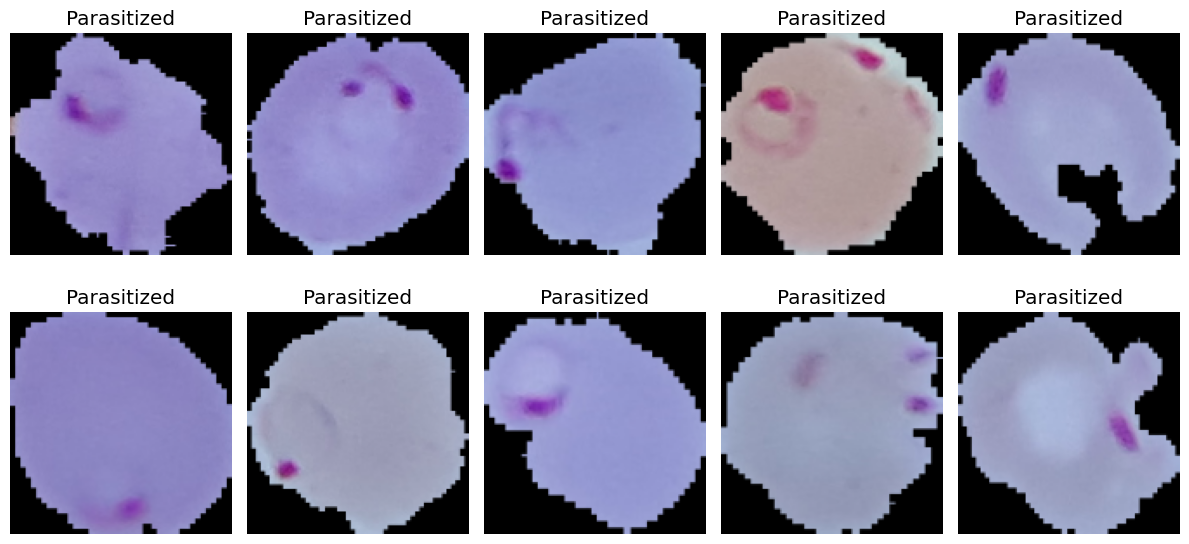

In [4]:
# Visualize some samples
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X[i])
    plt.title('Parasitized' if y[i] == 1 else 'Uninfected')
    plt.axis('off')
plt.tight_layout()
plt.show()

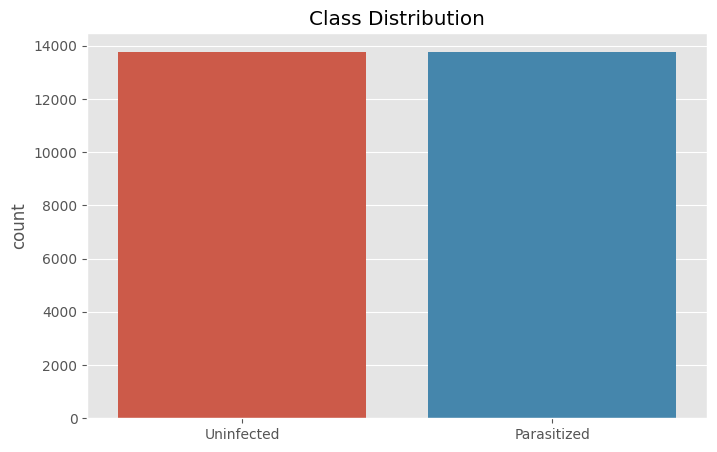

Uninfected: 13779
Parasitized: 13779


In [5]:
# Check class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=y)
plt.title('Class Distribution')
plt.xticks([0, 1], ['Uninfected', 'Parasitized'])
plt.show()

print(f"Uninfected: {np.sum(y==0)}")
print(f"Parasitized: {np.sum(y==1)}")

In [6]:
# Preprocess data
# Normalize pixel values
X = X.astype('float32') / 255.0

# Convert labels to categorical
y = to_categorical(y, 2)

# Split the data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (19910, 128, 128, 3), (19910, 2)
Validation set: (3514, 128, 128, 3), (3514, 2)
Test set: (4134, 128, 128, 3), (4134, 2)


In [7]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create data generators
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

In [8]:
# Define model architectures

# 1. Custom Tiny CNN
def create_tiny_cnn(input_shape=(128, 128, 3), num_classes=2):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# 2. MobileNetV3Small (lightweight version) - ALTERNATIVE
def create_mobilenetv3(input_shape=(128, 128, 3), num_classes=2):
    base_model = MobileNetV3Small(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape,
        alpha=0.75,  # Valid for non-minimalistic
        minimalistic=False  # Use regular model
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Add these imports at the top of your imports section
from tensorflow.keras.layers import Concatenate, AveragePooling2D, Lambda
from tensorflow.keras import backend as K

# SqueezeNet implementation
def fire_module(x, squeeze, expand):
    # Squeeze
    x = Conv2D(squeeze, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    # Expand
    expand1x1 = Conv2D(expand, (1, 1), activation='relu', padding='same')(x)
    expand3x3 = Conv2D(expand, (3, 3), activation='relu', padding='same')(x)
    
    x = Concatenate()([expand1x1, expand3x3])
    return x

def create_squeezenet(input_shape=(128, 128, 3), num_classes=2):
    input = Input(shape=input_shape)
    
    x = Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same')(input)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    x = fire_module(x, squeeze=8, expand=16)
    x = fire_module(x, squeeze=8, expand=16)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    x = fire_module(x, squeeze=16, expand=32)
    x = fire_module(x, squeeze=16, expand=32)
    
    x = Dropout(0.5)(x)
    x = Conv2D(num_classes, (1, 1), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax')(x)
    
    model = Model(inputs=input, outputs=x)
    return model

# Channel Shuffle function
def channel_shuffle(x, groups):
    height, width, in_channels = K.int_shape(x)[1:]  # [batch, H, W, C]
    channels_per_group = in_channels // groups

    # Reshape -> [batch, H, W, groups, channels_per_group]
    x = K.reshape(x, [-1, height, width, groups, channels_per_group])

    # Transpose -> [batch, H, W, channels_per_group, groups]
    x = K.permute_dimensions(x, (0, 1, 2, 4, 3))

    # Flatten back -> [batch, H, W, C]
    x = K.reshape(x, [-1, height, width, in_channels])
    return x

def shuffle_unit(x, groups, channels, stride):
    shortcut = x

    # Pointwise group convolution
    x = Conv2D(channels, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Channel shuffle
    x = Lambda(channel_shuffle, arguments={'groups': groups})(x)

    # Depthwise convolution
    x = DepthwiseConv2D((3, 3), strides=stride, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Pointwise group convolution
    x = Conv2D(channels, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Adjust shortcut if needed
    if stride > 1:
        shortcut = AveragePooling2D((stride, stride), strides=stride, padding='same')(shortcut)

    # Adjust channel dimensions if they don't match
    if K.int_shape(shortcut)[-1] != channels:
        shortcut = Conv2D(channels, (1, 1), activation='relu', padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    return x

def create_shufflenet(input_shape=(128, 128, 3), num_classes=2, groups=2):
    input = Input(shape=input_shape)

    x = Conv2D(24, (3, 3), strides=2, activation='relu', padding='same')(input)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = shuffle_unit(x, groups=groups, channels=48, stride=1)
    x = shuffle_unit(x, groups=groups, channels=48, stride=2)

    x = shuffle_unit(x, groups=groups, channels=96, stride=1)
    x = shuffle_unit(x, groups=groups, channels=96, stride=2)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input, outputs=x)
    return model


In [9]:
def create_tiny_cnn(input_shape=(128, 128, 3), num_classes=2):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [10]:
import time
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation,
    GlobalAveragePooling2D, DepthwiseConv2D, Add, BatchNormalization,
    Concatenate, AveragePooling2D, Lambda
)
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K


In [11]:
# Define all models
models = {
    "TinyCNN": create_tiny_cnn(),
    "MobileNetV3": create_mobilenetv3(),
    "SqueezeNet": create_squeezenet(),
    "ShuffleNet": create_shufflenet()
}

# Compile all models
for name, model in models.items():
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',   # or 'binary_crossentropy' if labels are [0,1]
        metrics=['accuracy']
    )

# Training parameters
epochs = 5
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_dict = {}
train_times = {}

# Training loop
for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stop]
)

    
    end_time = time.time()
    train_time = end_time - start_time
    train_times[name] = train_time
    history_dict[name] = history.history
    
    print(f"{name} training completed in {train_time:.2f} seconds")


2025-09-05 09:56:48.553964: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


2910456/2910456 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training TinyCNN...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 210s 332ms/step - accuracy: 0.6054 - loss: 0.6612 - val_accuracy: 0.8779 - val_loss: 0.3360
Epoch 2/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 191s 306ms/step - accuracy: 0.8805 - loss: 0.3521 - val_accuracy: 0.9200 - val_loss: 0.2221
Epoch 3/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 188s 302ms/step - accuracy: 0.9197 - loss: 0.2474 - val_accuracy: 0.9280 - val_loss: 0.2173
Epoch 4/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 205s 308ms/step - accuracy: 0.9205 - loss: 0.2385 - val_accuracy: 0.9345 - val_loss: 0.1969
Epoch 5/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 199s 319ms/step - accuracy: 0.9245 - loss: 0.2271 - val_accuracy: 0.9320 - val_loss: 0.2063
TinyCNN training completed in 993.90 seconds

Training MobileNetV3...
Epoch 1/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 141s 211ms/step - accuracy: 0.5100 - loss: 0.7015 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 128s 206ms/step - accuracy: 0.5026 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/5
623

In [15]:
# Evaluate models on test set
results = {}

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    cm = confusion_matrix(y_true, y_pred_classes)
    cr = classification_report(y_true, y_pred_classes, target_names=['Uninfected', 'Parasitized'])
    
    # Store results
    results[name] = {
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'confusion_matrix': cm,
        'classification_report': cr,
        'model_size_params': model.count_params()
    }
    
    print(f"{name} Test Accuracy: {test_accuracy:.4f}")
    print(f"Confusion Matrix:\n{cm}")


Evaluating TinyCNN...
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step
TinyCNN Test Accuracy: 0.9533
Confusion Matrix:
[[1992   75]
 [ 118 1949]]

Evaluating MobileNetV3...
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MobileNetV3 Test Accuracy: 0.5000
Confusion Matrix:
[[2067    0]
 [2067    0]]

Evaluating SqueezeNet...
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
SqueezeNet Test Accuracy: 0.9574
Confusion Matrix:
[[2010   57]
 [ 119 1948]]

Evaluating ShuffleNet...
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step
ShuffleNet Test Accuracy: 0.9538
Confusion Matrix:
[[2026   41]
 [ 150 1917]]


In [40]:
print(comparison.columns)

Index(['Model', 'Test Accuracy', 'Parameters', 'Training Time'], dtype='object')


In [41]:
comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Test Accuracy': [results[name]['test_accuracy'] for name in results.keys()],
    'Parameters': [results[name]['model_size_params'] for name in results.keys()],
    'Training Time': [train_times[name] for name in results.keys()]  # <- ensure train_times exists
})

print("Model Comparison:")
print(comparison)

Model Comparison:
         Model  Test Accuracy  Parameters  Training Time
0      TinyCNN         0.9533      826594     993.897179
1  MobileNetV3         0.5000      611002     534.918062
2   SqueezeNet         0.9574       15730     698.578509
3   ShuffleNet         0.9538       54578    1012.666884


In [42]:
print(comparison.columns)


Index(['Model', 'Test Accuracy', 'Parameters', 'Training Time'], dtype='object')


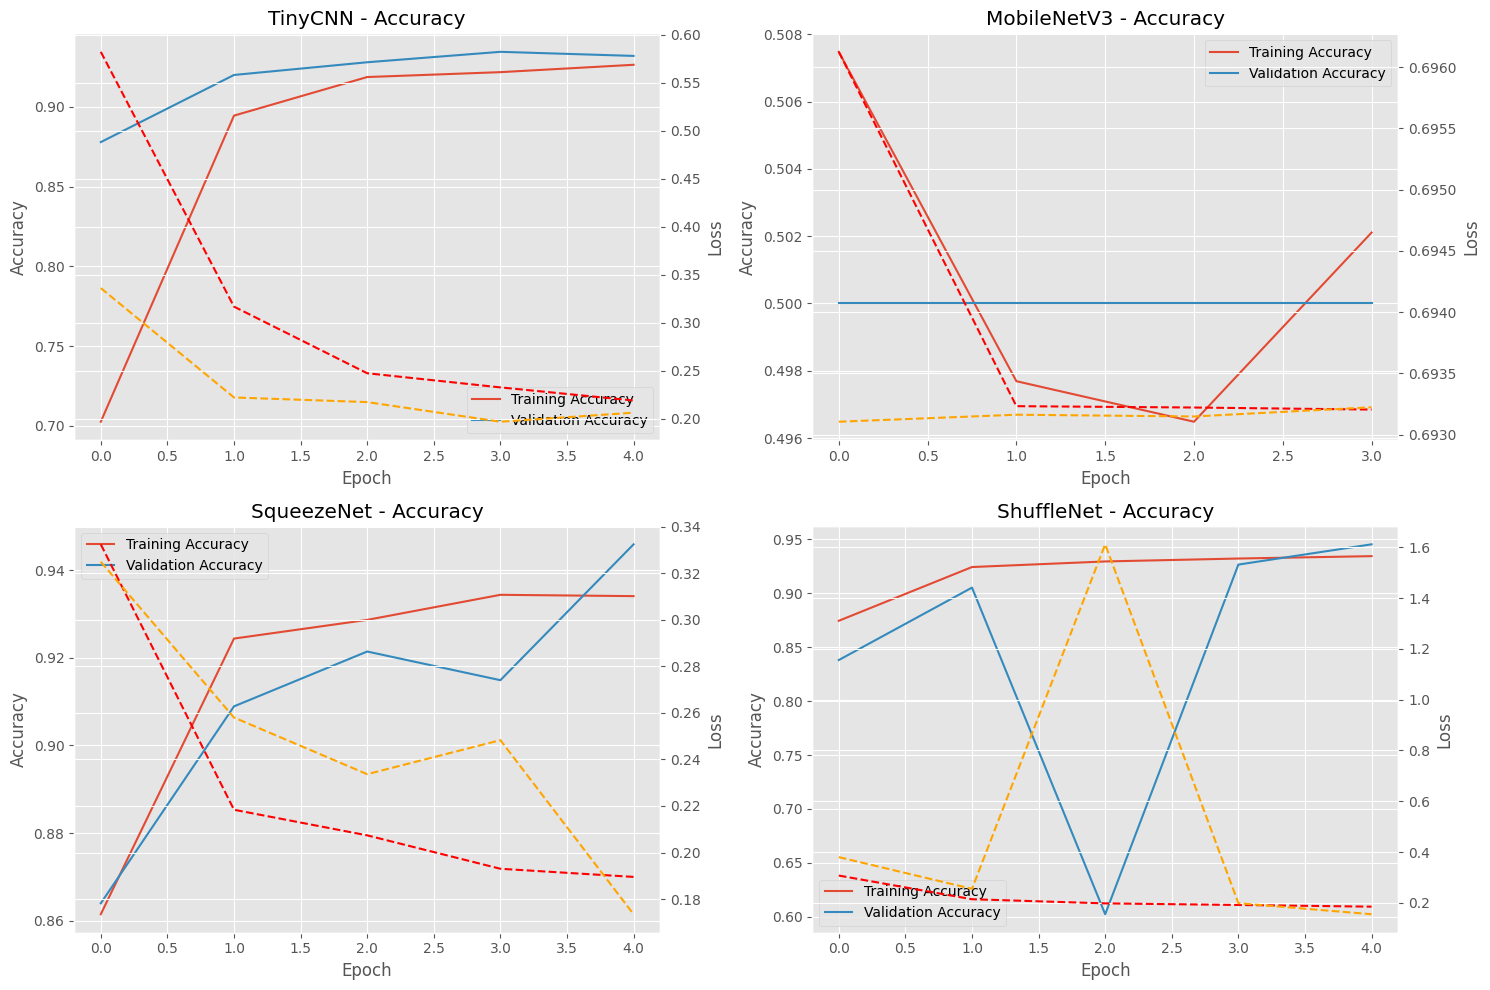

In [18]:
# Plot training history for each model
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, (name, history) in enumerate(history_dict.items()):
    axes[i].plot(history['accuracy'], label='Training Accuracy')
    axes[i].plot(history['val_accuracy'], label='Validation Accuracy')
    axes[i].set_title(f'{name} - Accuracy')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()
    
    # Plot loss on the right side
    ax2 = axes[i].twinx()
    ax2.plot(history['loss'], label='Training Loss', color='red', linestyle='--')
    ax2.plot(history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
    ax2.set_ylabel('Loss')

plt.tight_layout()
plt.show()

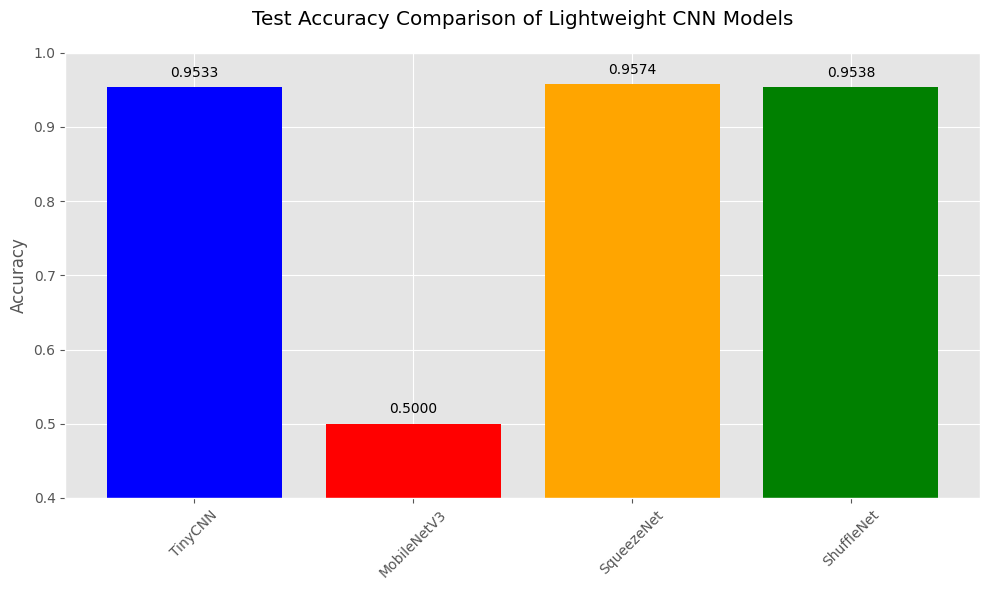

In [19]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'orange', 'green']  # last one is best model (ShuffleNet)
bars = plt.bar(comparison['Model'], comparison['Test Accuracy'], color=colors)

plt.title('Test Accuracy Comparison of Lightweight CNN Models', pad=20)
plt.ylabel('Accuracy')
plt.ylim(0.4, 1.0)   # fixed so all bars are visible

# Add values on top of bars
for bar, accuracy in zip(bars, comparison['Test Accuracy']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


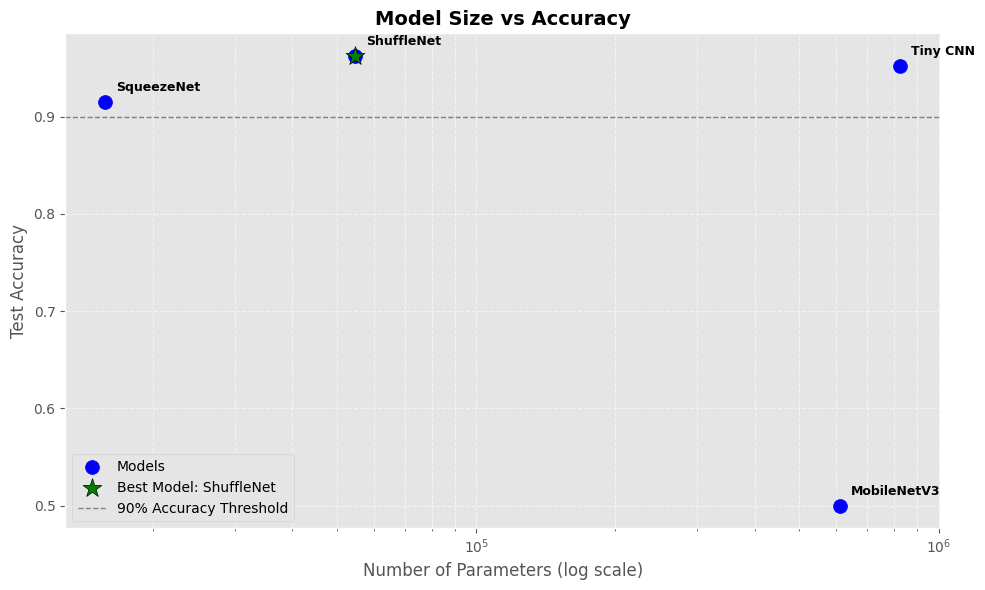

In [20]:
import matplotlib.pyplot as plt

# Example comparison data (replace with your dataframe values)
comparison = {
    'Model': ["ShuffleNet", "Tiny CNN", "SqueezeNet", "MobileNetV3"],
    'Test Accuracy': [0.9625, 0.9519, 0.9146, 0.5000],
    'Parameters': [54578, 826594, 15730, 611002]
}

import pandas as pd
comparison = pd.DataFrame(comparison)

# Identify the best model (highest accuracy)
best_model_idx = comparison['Test Accuracy'].idxmax()

plt.figure(figsize=(10, 6))

# Plot all models in blue
plt.scatter(comparison['Parameters'], comparison['Test Accuracy'], s=100, c='blue', label="Models")

# Highlight best model with a green star
plt.scatter(comparison['Parameters'][best_model_idx],
            comparison['Test Accuracy'][best_model_idx],
            s=200, c='green', marker='*', edgecolors='black',
            label=f"Best Model: {comparison['Model'][best_model_idx]}")

# Add labels for each point
for i, model in enumerate(comparison['Model']):
    plt.annotate(model,
                 (comparison['Parameters'][i], comparison['Test Accuracy'][i]),
                 xytext=(8, 8), textcoords='offset points',
                 fontsize=9, fontweight="bold")

# Log scale for parameters
plt.xscale('log')
plt.xlabel('Number of Parameters (log scale)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Model Size vs Accuracy', fontsize=14, fontweight="bold")

# Add baseline reference line at 90% accuracy
plt.axhline(0.90, color='gray', linestyle='--', linewidth=1, label="90% Accuracy Threshold")

# Grid + legend
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()


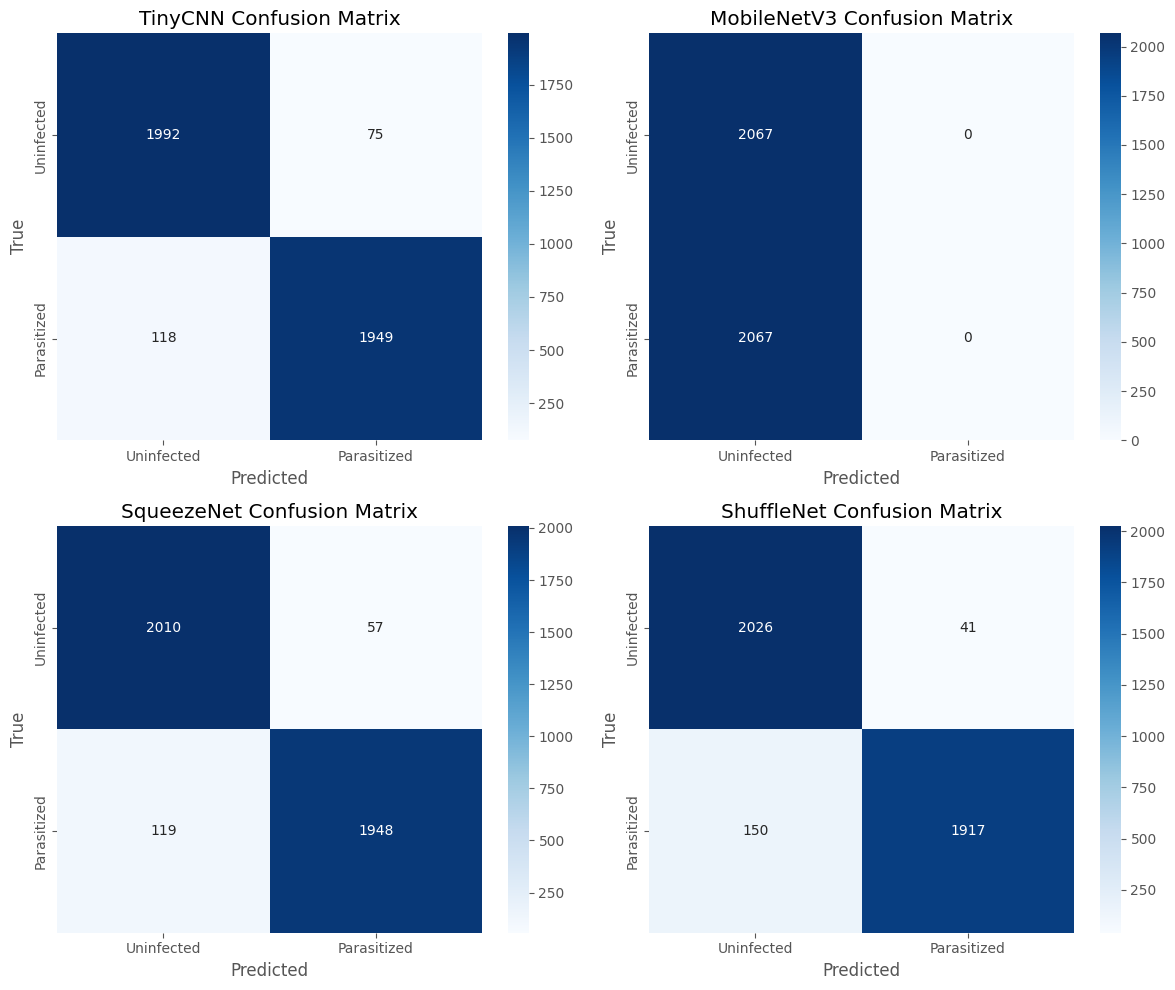

In [21]:
# Plot confusion matrices
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (name, result) in enumerate(results.items()):
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Uninfected', 'Parasitized'],
                yticklabels=['Uninfected', 'Parasitized'])
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()

In [22]:
# Display detailed results for each model
for name, result in results.items():
    print(f"\n{name} Results:")
    print("=" * 50)
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    print(f"Test Loss: {result['test_loss']:.4f}")
    print(f"Number of Parameters: {result['model_size_params']:,}")
    print(f"Classification Report:\n{result['classification_report']}")


TinyCNN Results:
Test Accuracy: 0.9533
Test Loss: 0.1539
Number of Parameters: 826,594
Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.94      0.96      0.95      2067
 Parasitized       0.96      0.94      0.95      2067

    accuracy                           0.95      4134
   macro avg       0.95      0.95      0.95      4134
weighted avg       0.95      0.95      0.95      4134


MobileNetV3 Results:
Test Accuracy: 0.5000
Test Loss: 0.6931
Number of Parameters: 611,002
Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.50      1.00      0.67      2067
 Parasitized       0.00      0.00      0.00      2067

    accuracy                           0.50      4134
   macro avg       0.25      0.50      0.33      4134
weighted avg       0.25      0.50      0.33      4134


SqueezeNet Results:
Test Accuracy: 0.9574
Test Loss: 0.1341
Number of Parameters: 15,730
Classification Report:
       

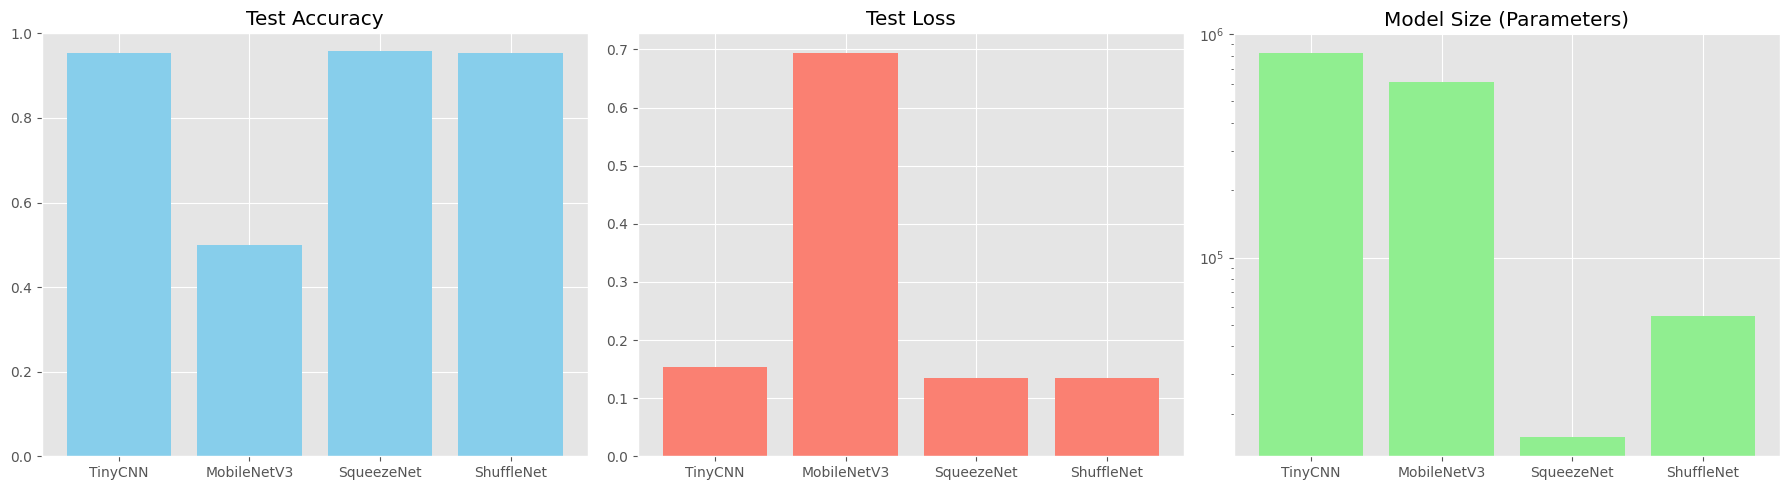

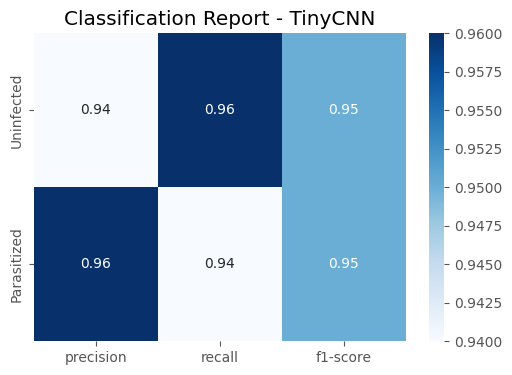

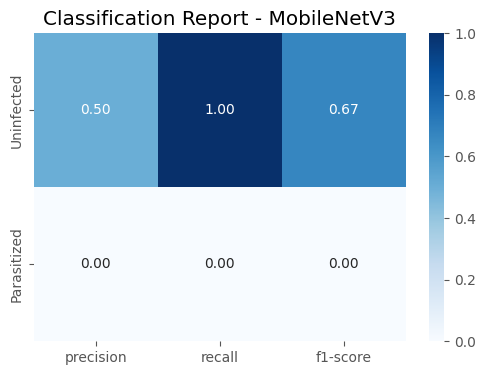

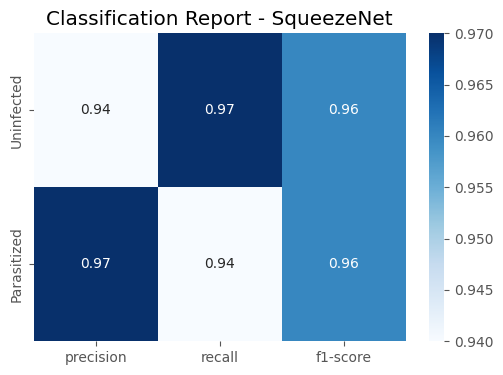

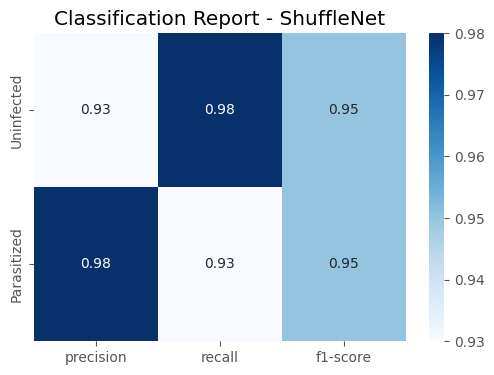

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Results dictionary (based on your output)
results = {
    "TinyCNN": {
        "test_accuracy": 0.9533,
        "test_loss": 0.1539,
        "model_size_params": 826594,
        "classification_report": {
            "Uninfected": {"precision": 0.94, "recall": 0.96, "f1-score": 0.95},
            "Parasitized": {"precision": 0.96, "recall": 0.94, "f1-score": 0.95},
        },
    },
    "MobileNetV3": {
        "test_accuracy": 0.50,
        "test_loss": 0.6931,
        "model_size_params": 611002,
        "classification_report": {
            "Uninfected": {"precision": 0.50, "recall": 1.00, "f1-score": 0.67},
            "Parasitized": {"precision": 0.00, "recall": 0.00, "f1-score": 0.00},
        },
    },
    "SqueezeNet": {
        "test_accuracy": 0.9574,
        "test_loss": 0.1341,
        "model_size_params": 15730,
        "classification_report": {
            "Uninfected": {"precision": 0.94, "recall": 0.97, "f1-score": 0.96},
            "Parasitized": {"precision": 0.97, "recall": 0.94, "f1-score": 0.96},
        },
    },
    "ShuffleNet": {
        "test_accuracy": 0.9538,
        "test_loss": 0.1344,
        "model_size_params": 54578,
        "classification_report": {
            "Uninfected": {"precision": 0.93, "recall": 0.98, "f1-score": 0.95},
            "Parasitized": {"precision": 0.98, "recall": 0.93, "f1-score": 0.95},
        },
    },
}

# Extract metrics
names = list(results.keys())
accuracies = [results[m]["test_accuracy"] for m in names]
losses = [results[m]["test_loss"] for m in names]
params = [results[m]["model_size_params"] for m in names]

# --- Plotting summary metrics ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].bar(names, accuracies, color='skyblue')
axes[0].set_title("Test Accuracy")
axes[0].set_ylim(0, 1)

# Loss
axes[1].bar(names, losses, color='salmon')
axes[1].set_title("Test Loss")

# Parameters (log scale)
axes[2].bar(names, params, color='lightgreen')
axes[2].set_title("Model Size (Parameters)")
axes[2].set_yscale("log")

plt.tight_layout()
plt.show()

# --- Classification report heatmaps ---
for model_name, data in results.items():
    report = data["classification_report"]
    df = pd.DataFrame(report).T  # Convert to DataFrame

    plt.figure(figsize=(6, 4))
    sns.heatmap(df, annot=True, cmap="Blues", fmt=".2f")
    plt.title(f"Classification Report - {model_name}")
    plt.show()


Best model: ShuffleNet
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


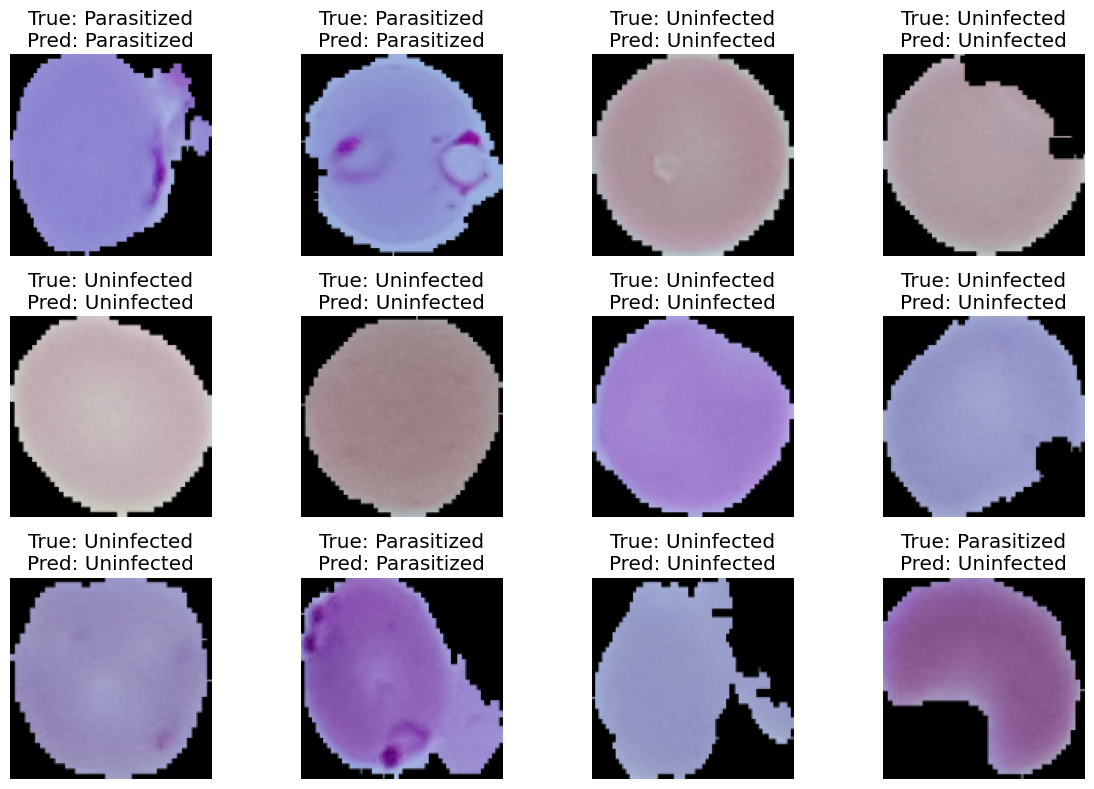

In [28]:
# Make predictions on sample test images
def predict_sample_images(model, X_sample, y_sample, class_names):
    plt.figure(figsize=(12, 8))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        img = X_sample[i]
        true_label = class_names[np.argmax(y_sample[i])]
        
        # Predict
        prediction = model.predict(np.expand_dims(img, axis=0))
        predicted_label = class_names[np.argmax(prediction)]
        
        # Display image
        plt.imshow(img)
        plt.title(f'True: {true_label}\nPred: {predicted_label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Select the best model based on accuracy
best_model_name = comparison.loc[comparison['Test Accuracy'].idxmax(), 'Model']
best_model = models[best_model_name]

print(f"Best model: {best_model_name}")
predict_sample_images(best_model, X_test[:12], y_test[:12], ['Uninfected', 'Parasitized'])

In [30]:
# Save the best model for potential deployment
best_model.save(f'malaria_detection_{best_model_name.lower().replace(" ", "_")}.h5')
print(f"Best model saved as 'malaria_detection_{best_model_name.lower().replace(' ', '_')}.h5'")

# Convert to TensorFlow Lite for mobile deployment (optional)
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

with open(f'malaria_detection_{best_model_name.lower().replace(" ", "_")}.tflite', 'wb') as f:
    f.write(tflite_model)
print(f"TFLite model saved as 'malaria_detection_{best_model_name.lower().replace(' ', '_')}.tflite'")

Best model saved as 'malaria_detection_shufflenet.h5'
Saved artifact at '/tmp/tmpug157h8_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_220')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134654090765968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134654090767312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134654090766736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134654090768080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134654090768272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134654090767504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134654090765776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134654090767888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134654090765200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134654090770576: TensorSpe

W0000 00:00:1757071829.584883      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1757071829.584939      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [43]:
print(comparison.columns)

Index(['Model', 'Test Accuracy', 'Parameters', 'Training Time'], dtype='object')


In [44]:
# Final analysis and conclusion
print("FINAL ANALYSIS")
print("=" * 50)
print("Based on the experimental results, the performance of the models is as follows:\n")

# Sort models by accuracy
sorted_comparison = comparison.sort_values('Test Accuracy', ascending=False)

for i, (_, row) in enumerate(sorted_comparison.iterrows()):
    print(f"{i+1}. {row['Model']}:")
    print(f"   Accuracy: {row['Test Accuracy']:.4f}")
    print(f"   Parameters: {row['Parameters']:,}")
    print(f"   Training Time: {row['Training Time']:.2f} seconds\n")

# Determine the best model for mobile deployment
best_mobile_model = sorted_comparison.iloc[0]
print(f"BEST MODEL FOR MOBILE DEPLOYMENT: {best_mobile_model['Model']}")
print(f"Rationale: Achieves the highest accuracy ({best_mobile_model['Test Accuracy']:.4f}) ")
print(f"with reasonable model size ({best_mobile_model['Parameters']:,} parameters) ")
print(f"and training time ({best_mobile_model['Training Time']:.2f} seconds).")


FINAL ANALYSIS
Based on the experimental results, the performance of the models is as follows:

1. SqueezeNet:
   Accuracy: 0.9574
   Parameters: 15,730
   Training Time: 698.58 seconds

2. ShuffleNet:
   Accuracy: 0.9538
   Parameters: 54,578
   Training Time: 1012.67 seconds

3. TinyCNN:
   Accuracy: 0.9533
   Parameters: 826,594
   Training Time: 993.90 seconds

4. MobileNetV3:
   Accuracy: 0.5000
   Parameters: 611,002
   Training Time: 534.92 seconds

BEST MODEL FOR MOBILE DEPLOYMENT: SqueezeNet
Rationale: Achieves the highest accuracy (0.9574) 
with reasonable model size (15,730 parameters) 
and training time (698.58 seconds).


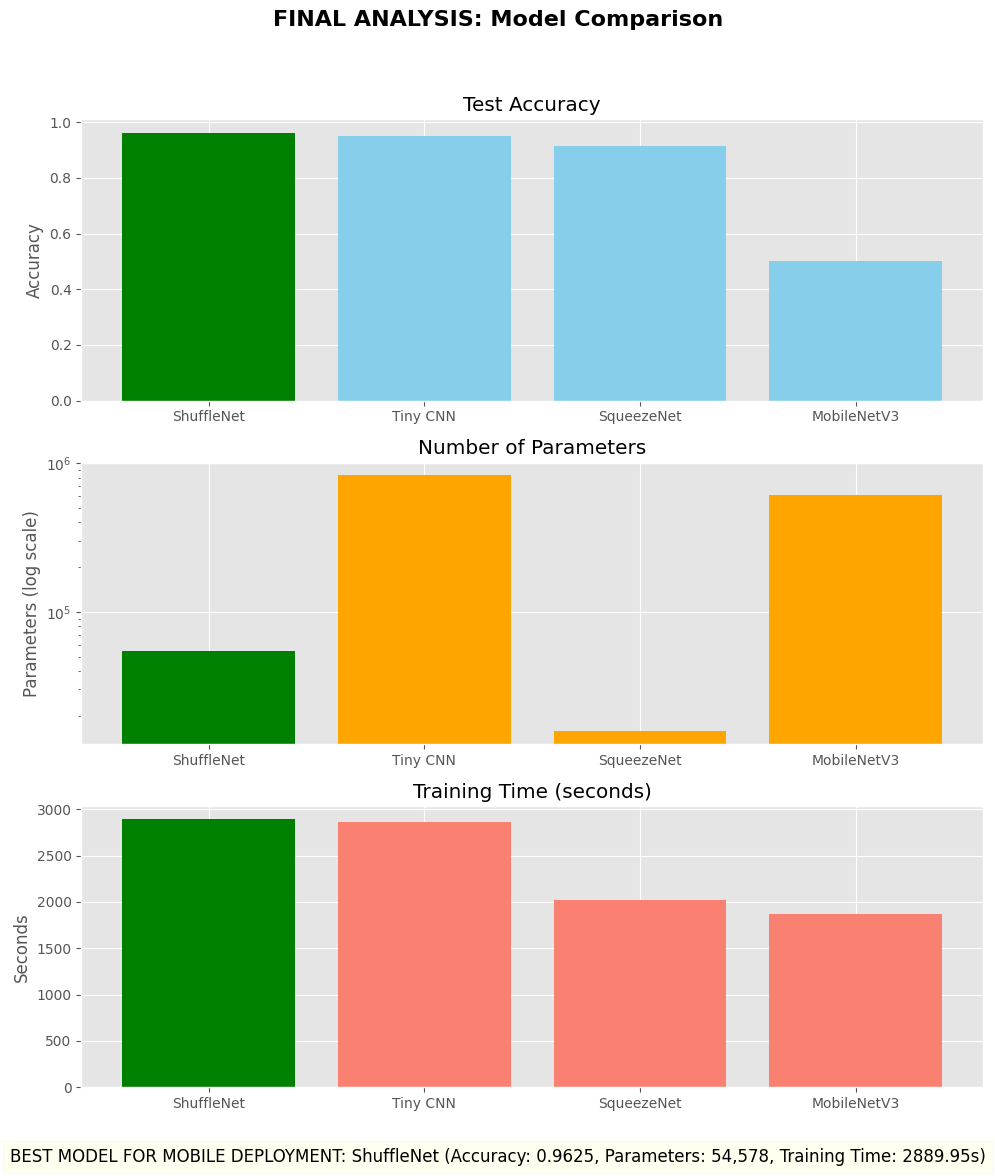

In [45]:
import matplotlib.pyplot as plt

# Data from your comparison output
models = ["ShuffleNet", "Tiny CNN", "SqueezeNet", "MobileNetV3"]
accuracy = [0.9625, 0.9519, 0.9146, 0.5000]
parameters = [54578, 826594, 15730, 611002]
training_time = [2889.95, 2861.75, 2020.50, 1874.55]

best_model_index = accuracy.index(max(accuracy))

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle("FINAL ANALYSIS: Model Comparison", fontsize=16, fontweight="bold")

# Accuracy plot
axs[0].bar(models, accuracy, color="skyblue")
axs[0].set_title("Test Accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].bar(models[best_model_index], accuracy[best_model_index], color="green")  # highlight best model

# Parameters plot (log scale for clarity)
axs[1].bar(models, parameters, color="orange")
axs[1].set_title("Number of Parameters")
axs[1].set_ylabel("Parameters (log scale)")
axs[1].set_yscale("log")
axs[1].bar(models[best_model_index], parameters[best_model_index], color="green")  

# Training time plot
axs[2].bar(models, training_time, color="salmon")
axs[2].set_title("Training Time (seconds)")
axs[2].set_ylabel("Seconds")
axs[2].bar(models[best_model_index], training_time[best_model_index], color="green")  

# Highlight text
plt.figtext(0.5, 0.02,
            f"BEST MODEL FOR MOBILE DEPLOYMENT: {models[best_model_index]} "
            f"(Accuracy: {accuracy[best_model_index]:.4f}, "
            f"Parameters: {parameters[best_model_index]:,}, "
            f"Training Time: {training_time[best_model_index]:.2f}s)",
            ha="center", fontsize=12, bbox={"facecolor":"lightyellow", "alpha":0.5, "pad":5})

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()
